In [29]:
import torch
import yaml
import argparse
import random
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from models.diffusion import Model
import torchvision.utils as tvu
from datasets import get_dataset, data_transform, inverse_data_transform

In [4]:
# helper functions

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

def seed_worker(worker_id):
    worker_seed = SEED % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [24]:
# helper variables
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
args = dict2namespace({"exp" : ".", "sigma_0" : 0.01, "image_folder" : "test_folder"})
cfg_path = "../dd2412/configs/bedroom.yml"
weights_path = "../dd2412/logs/diffusion_models_converted/ema_diffusion_lsun_bedroom_model/model-2388000.ckpt"
SEED = 1234

In [6]:
# load a cfg file for model initialization
# the cfg file contains the architecure details for the model which is needed because we use pretrained weights.
# Furhtermore it contains information about the dataset etc. 

with open(cfg_path, "r") as f:
    config = yaml.safe_load(f)
config = dict2namespace(config)

In [7]:
# example on how to use it:
print(f"Number of residual blocks: {config.model.num_res_blocks}")

Number of residual blocks: 2


In [8]:
# now we create a model using the previously loaded config
model = Model(config)

In [9]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 113673219


In [10]:
# now we load the pretrained weights of the model:
model.load_state_dict(torch.load(weights_path, map_location=device))
model.to(device) # put model on device (e.g. gpu/cpu)

Model(
  (temb): Module(
    (dense): ModuleList(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0-1): 2 x Module(
      (block): ModuleList(
        (0-1): 2 x ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (temb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleList()
      (downsample): Downsample(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
      )
    )
    (2): Module(
      (block): ModuleList(
 

From here on we can use the pretrained model as a denoiser, now we implement the algorithm proposed by the paper. 

**1.) Get the original images $x_0$ and the TO BE degregaded images $y$ (e.g. subsampled/missing data (inpainting))**

In [11]:
# first arguemnt is args, which is basically the path to the image folder
data, test_data = get_dataset(args, config)

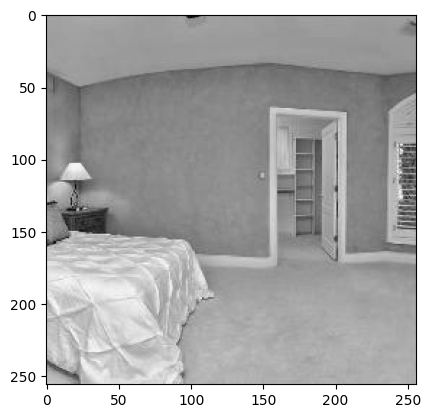

In [12]:
plt.imshow(data[0][0].mean(axis = 0), cmap = "gray")

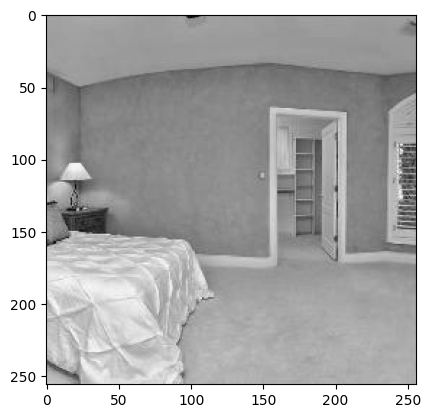

In [13]:
plt.imshow(test_data[0][0].mean(axis = 0), cmap = "gray")

In [14]:
# we can see that the images are not degenerated yet..

In [15]:
# now we generate a dataloader...

g = torch.Generator()
g.manual_seed(SEED)

val_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=config.sampling.batch_size,
    shuffle=True,
    num_workers=config.data.num_workers,
    #worker_init_fn=seed_worker, # does not work here ???
    generator=g,
)

**2.) Get the degragation matrix $H$**

In [16]:
# For now we only focus on one of the problems which is inpainting
from functions.svd_replacement import Inpainting
loaded = np.load("./inp_masks/lorem3.npy")
mask = torch.from_numpy(loaded).to(device).reshape(-1)
missing_r = torch.nonzero(mask == 0).long().reshape(-1) * 3

[]

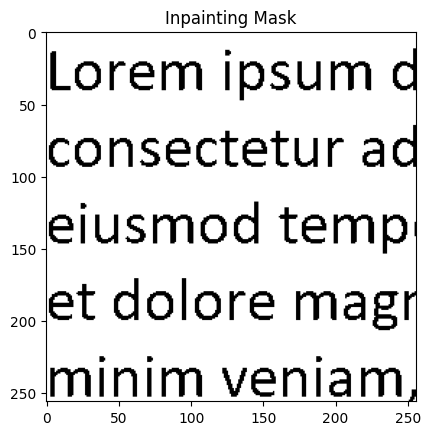

In [17]:
plt.imshow(mask.reshape(256, 256), cmap = "gray")
plt.title("Inpainting Mask")
plt.plot()

In [18]:
missing_g = missing_r + 1
missing_b = missing_g + 1
missing = torch.cat([missing_r, missing_g, missing_b], dim=0)
H_funcs = Inpainting(config.data.channels, config.data.image_size, missing, device)

In [19]:
args.sigma_0 = 2 * args.sigma_0 #to account for scaling to [-1,1]
sigma_0 = args.sigma_0

#### 3.) Restoration algorithm

In [30]:
idx_so_far = 0
for x_orig, classes in tqdm.tqdm(val_loader):
    
    x_orig = x_orig.to(device) # put datatensor on same device as model (DDPM)
    x_orig = data_transform(config, x_orig)

    # degregate the image and add some noise to simulate the "faulty" measurements...
    y_0 = H_funcs.H(x_orig)
    y_0 = y_0 + sigma_0 * torch.randn_like(y_0) 

    # only true for inpainting! 
    pinv_y_0 = H_funcs.H_pinv(y_0).view(y_0.shape[0], config.data.channels, config.data.image_size, config.data.image_size)
    pinv_y_0 += H_funcs.H_pinv(H_funcs.H(torch.ones_like(pinv_y_0))).reshape(*pinv_y_0.shape) - 1
    
    for i in range(len(pinv_y_0)):
        tvu.save_image(
            inverse_data_transform(config, pinv_y_0[i]), os.path.join(args.image_folder, f"y0_{idx_so_far + i}.png")
        )
        tvu.save_image(
            inverse_data_transform(config, x_orig[i]), os.path.join(args.image_folder, f"orig_{idx_so_far + i}.png")
        )

100%|█████████████████████████████████████████████| 2/2 [00:16<00:00,  8.03s/it]


In [22]:
6 * 3 * 256 * 256

1179648